# ОИАД. Лабораторная работа №2

Библиотеки

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Датасет
datasets/students_simple.csv 

Выбираются 2 слобика данных по формулам:
1) $N % 5$
2) $N^2$ % $5$ + $5$ где - $N$ номер в списке

In [7]:
ds = pd.read_csv("../datasets/students_simple.csv")
display(ds)

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5
5,164,58,290,98,16,20,2.828,14,6,10.0
6,166,51,480,109,90,26,3.255,78,9,7.2
7,169,62,610,120,24,19,2.726,10,5,4.2
8,170,70,840,122,48,30,2.429,130,10,3.5
9,170,72,330,92,24,20,2.361,20,3,9.5


In [9]:
number = 6
col1 = number % 5
col2 = number ** 2 % 5 + 5
df = pd.read_csv("../datasets/students_simple.csv", usecols=[col1, col2])
display(df)

,mass,bmi
0,45,3.533
1,61,2.623
2,56,2.875
3,48,3.375
4,54,3.000
5,58,2.828
6,51,3.255
7,62,2.726
8,70,2.429
9,72,2.361


In [11]:
col1_name = df.columns[0]
col2_name = df.columns[1]
x = df[col1_name].values
y = df[col2_name].values

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

## Коэффициент корреляции Фехнера

$K = \frac{C - H}{C + H}$

In [15]:
def fechner_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_dev = x - x_mean
    y_dev = y - y_mean
    
    x_sign = np.sign(x_dev)
    y_sign = np.sign(y_dev)
    
    C = 0  
    H = 0  
    
    for i in range(len(x_sign)):
        if x_sign[i] * y_sign[i] > 0: 
            C += 1
        elif x_sign[i] * y_sign[i] < 0:  
            H += 1
    
    K = (C - H) / (C + H)
    return K

In [17]:
fechner_corr = fechner_correlation(x, y)
print(f"1. Корреляция Фехнера: {fechner_corr:.4f}")

1. Корреляция Фехнера: -0.9000


## Коэффициент корреляции Пирсона

$r = \frac{cov(X, Y)}{\sigma_X\sigma_Y} = \frac{\sum_{i = 1}^{n}{(x_i - \overline{x})(y_i - \overline{y})}}{\sqrt{\sum_{i = 1}^{n}{(x_i - \overline{x})^2}\sum_{i = 1}^{n}{(y_i - \overline{y})^2} }}$

In [20]:
def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_dev = x - x_mean
    y_dev = y - y_mean
    
    numerator = np.sum(x_dev * y_dev)
    
    denominator = np.sqrt(np.sum(x_dev**2) * np.sum(y_dev**2))
    if denominator == 0:
        return 0
        
    r = numerator / denominator
    return r

def pearson_confidence_interval(r, n, confidence=0.95):    
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    
    z_critical = stats.norm.ppf((1 + confidence) / 2)
    
    z_lower = z - z_critical * se
    z_upper = z + z_critical * se
    
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return (r_lower, r_upper)

In [22]:
confidence = 0.95
r = pearson_correlation(x, y)
ci_lower, ci_upper = pearson_confidence_interval(r, len(x), confidence)
print(f"2. Кореляция Пирсона: {r:.4f}")
print(f"Доверительный интервал {confidence*100}%:[{ci_lower:.4f}, {ci_upper:.4f}]")

2. Кореляция Пирсона: -0.9606
Доверительный интервал 95.0%:[-0.9846, -0.9012]


## Коэффициент ранговой корреляции Спирмена

$\rho = 1 - \frac{6\sum{d_i^{2}}}{n(n^2 - 1)}$

In [25]:
def spearman_correlation(x, y):
    n = len(x)
    x_ranks = stats.rankdata(x)
    y_ranks = stats.rankdata(y)

    d = x_ranks - y_ranks
    d_squared = d ** 2
    sum_d_squared = np.sum(d_squared)

    numerator = 6 * sum_d_squared
    denominator = n * (n**2 - 1)
    
    rho = 1 - (numerator / denominator)
    
    return rho

In [27]:
spearman_rho = spearman_correlation(x, y)
print(f"3. Корреляция Спирмена: {spearman_rho:.4f}")

3. Корреляция Спирмена: -0.9827


## Коэффициент корреляции Кенделла

$\tau=1-\frac{4}{n(n-1)}R$
,где $R = \sum_{i=1}^{n-1}\sum_{j=i+1}^n\left[ \left[ x_i\ <\ x_j \right] \neq \left[ y_i\ <\ y_j \right] \right]$ 
— количество инверсий, образованных величинами $y_i$, расположенными в порядке возрастания соответствующих $x_i$.

In [31]:
def kendall_correlation(x, y):
    n = len(x)
    indices = np.argsort(x)
    x_sorted = x[indices]
    y_sorted = y[indices]

    R = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            if y_sorted[i] > y_sorted[j]:
                R += 1
    
    tau = 1 - (4 * R) / (n * (n - 1))
    
    return tau

In [33]:
kendall_tau= kendall_correlation(x, y)
print(f"4. Корреляция Кенделла: {kendall_tau:.4f}")

4. Корреляция Кенделла: -0.9263


## Выводы

1) Корреляция Фехнера: -0.9000 - наблюдается сильная обратная связь
2) Корреляция Пирсона: -0.9606 - сильная отрицательная линейная связь, узкий доверительный интервал свидетельствует о высокой точности оценки
3) Корреляция Спирмена: -0.9827 - сильная обратная связь, сильная ранговая зависимость
4) Корреляция Кенделла: -0.9263 - сильная обратная согласованность рангов 

## 2. Визуализация

1. Гистограммы
2. График рассеяния (scatter plot)

In [39]:
def plot_histogram(x, column_name, bins=15, color='blue', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    n, bins, patches = plt.hist(x, bins=bins, color=color, alpha=0.7, edgecolor='black')
    
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.title(f'Гистограмма: {column_name}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

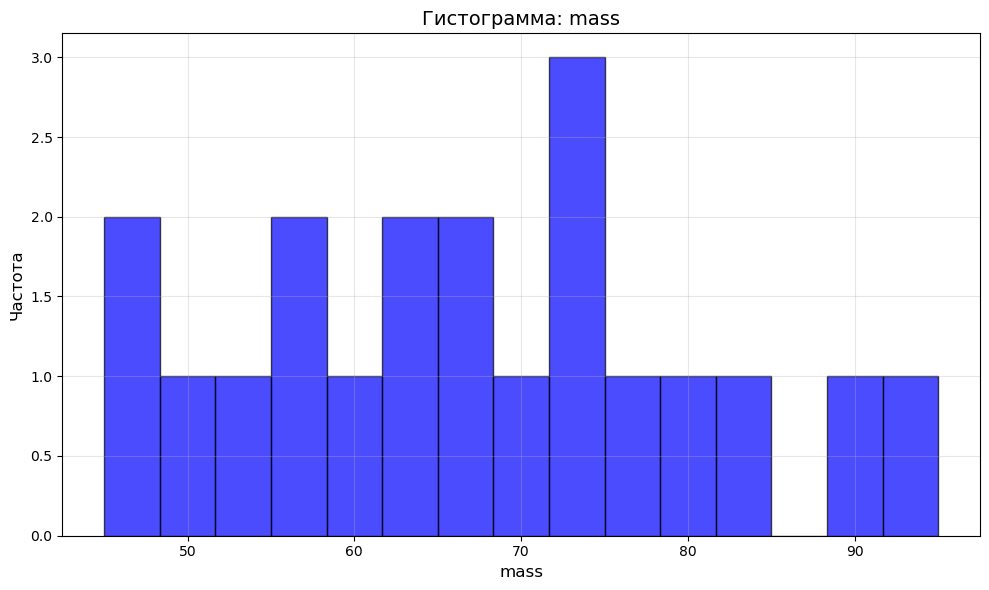

In [41]:
plot_histogram(x, col1_name)

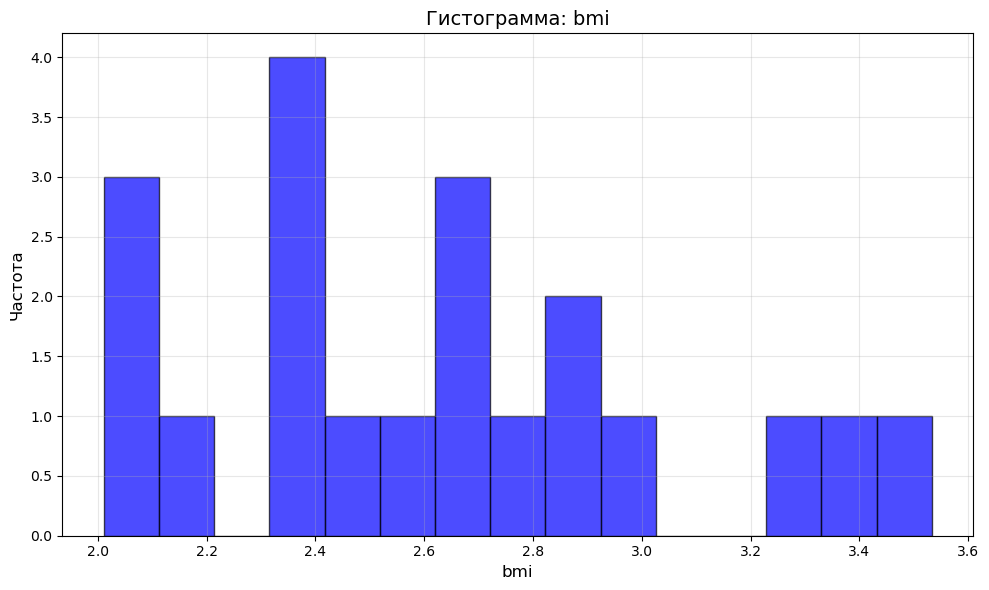

In [43]:
plot_histogram(y, col2_name)

In [45]:
def print_scatter(x, y, x_column, y_column, figsize=(10, 6), alpha=0.7, color='blue'):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=alpha, color=color, s=50)
    
    plt.xlabel(x_column, fontsize=12)
    plt.ylabel(y_column, fontsize=12)
    plt.title(f'Scatter Plot: {x_column} && {y_column}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

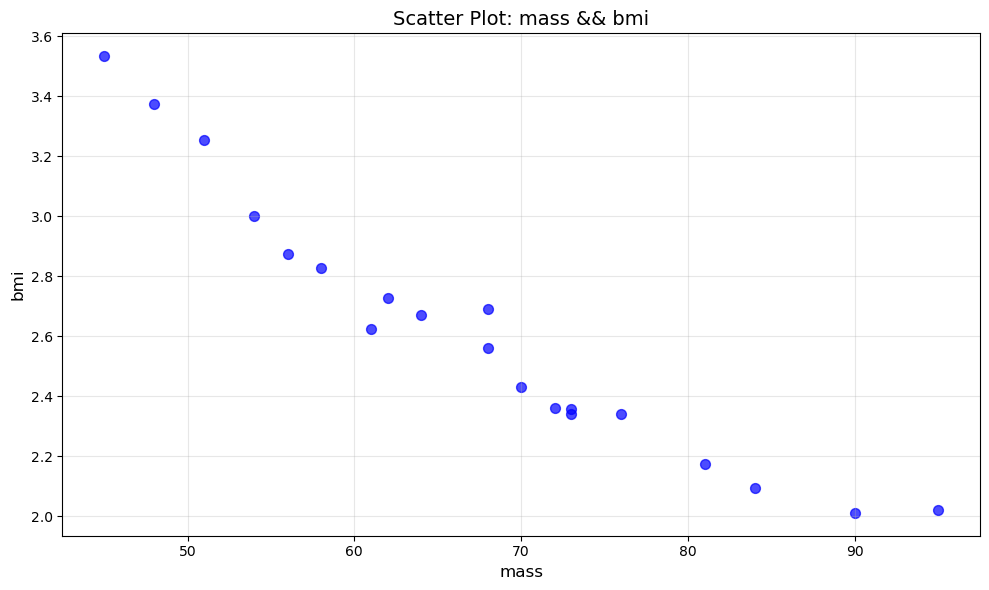

In [47]:
print_scatter(x, y, col1_name, col2_name)

## Выводы

График рассеяния показывает взаимосвязь между признаками. Можно предположить наличие линейной корреляции, так как визуально точки принадлежат одной прямой

## 3. Уравнение регрессии
Построить уравнение регрессии методом наименьших квадратов по видам
1. линейная, $y=w_1 x + w_0$ - расчёт коэффициентов реализовать саммому
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

## Линейная регрессия

$w_1 = \frac{n\sum{xy} - \sum{x}\sum{y}}{n\sum{x^2} - (\sum{x})^2}$


$w_0 = \frac{\sum{y} - w_1*\sum{x}}{n}$

In [52]:
def linear_regression(x, y):
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x * y)
    denominator = n * sum_x2 - sum_x**2
    w1 = (n * sum_xy - sum_x * sum_y) / denominator
    w0 = (sum_y - w1 * sum_x) / n
    return w0, w1

In [54]:
w0, w1 = linear_regression(x,y)
print(f'y = {w1:.4f}x + {w0:.4f}');

y = -0.0308x + 4.6881


In [56]:
def plot_linear_regression(x, y, w0, w1, x_label="X", y_label="Y", figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7, color='blue', s=50, label='Исходные данные')
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = w1 * x_line + w0
    plt.plot(x_line, y_line, 'r-', linewidth=2, label =  f'y = {w1:.4f}x + {w0:.4f}')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title('Линейная регрессия МНК', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

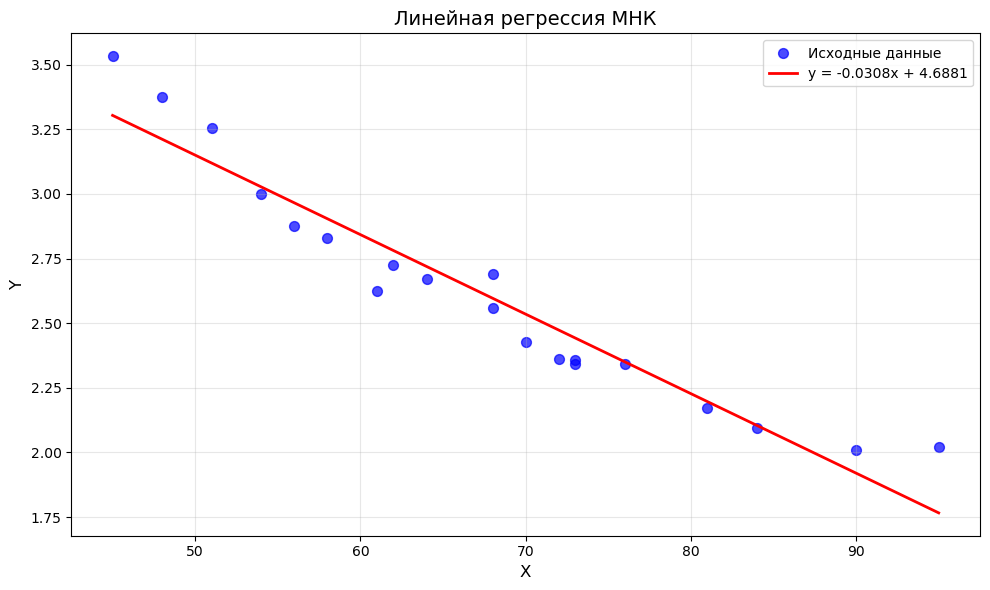

In [58]:
plot_linear_regression(x, y, w0, w1)

## Квадратичная регрессия
$y = w_2 x^2 + w_1 x + w_0$

In [61]:
def quadratic_regression(x, y):
    x = np.array(x).reshape(-1, 1)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(x)

    model = LinearRegression()
    model.fit(X_poly, y)

    w0 = model.intercept_
    w1, w2 = model.coef_

    coefficients = [w0, w1, w2]
    return coefficients

In [63]:
coeff = quadratic_regression(x, y)
print(f'y = {coeff[2]:.4f}x^2 + {coeff[1]:.4f}x + {coeff[0]:.4f}')

y = 0.0005x^2 + -0.0990x + 6.9596


In [65]:
def plot_quadratic_regression(x, y, coefficients, x_label="X", y_label="Y", figsize=(12, 8)):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7, color='blue', s=50, label='Исходные данные')
    x_line = np.linspace(np.min(x), np.max(x), 300)
    w0, w1, w2 = coefficients
    y_line = w2 * x_line**2 + w1 * x_line + w0
    plt.plot(x_line, y_line, 'r-', linewidth=3, label=f'Квадратичная регрессия: y = {coeff[2]:.4f}x^2 + {coeff[1]:.4f}x + {coeff[0]:.4f}')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title('Квадратичная регрессия', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

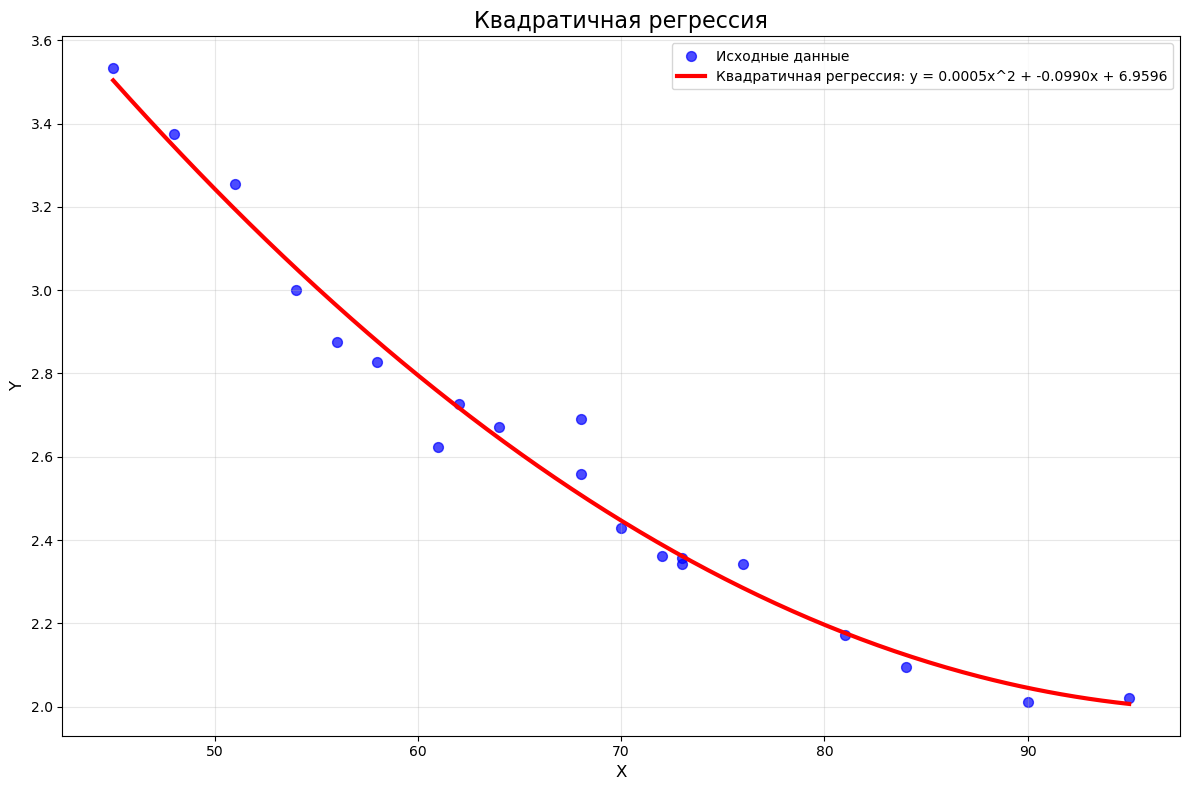

In [67]:
plot_quadratic_regression(x, y, coeff)

## Гиперболическая регрессия

$y = \frac{w_1}{x} + w_0$

In [70]:
def hyperbolic_regression(x, y):
    X_hyper = 1 / x
    model = LinearRegression()
    model.fit(X_hyper.reshape(-1, 1), y)
    w0 = model.intercept_
    w1 = model.coef_[0]

    coefficients = [w0, w1]
    
    return coefficients

In [72]:
coeff = hyperbolic_regression(x, y)
print(f'y = {coeff[1]:.4f}/x + {coeff[0]:.4f}')

y = 135.2427/x + 0.5275


In [74]:
def plot_hyperbolic_regression(x, y, coeff, x_label="X", y_label="Y", figsize=(12, 8)):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7, color='blue', s=50, label='Исходные данные')
    x_sorted = np.linspace(np.min(x[x > 0]), np.max(x), 300) 
    w0, w1 = coeff
    y_hyper = w0 + w1 / x_sorted
    plt.plot(x_sorted, y_hyper, 'r-', linewidth=3, label=f'Гиперболическая регрессия: y = {coeff[1]:.4f}/x + {coeff[0]:.4f}')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title('Гиперболическая регрессия', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

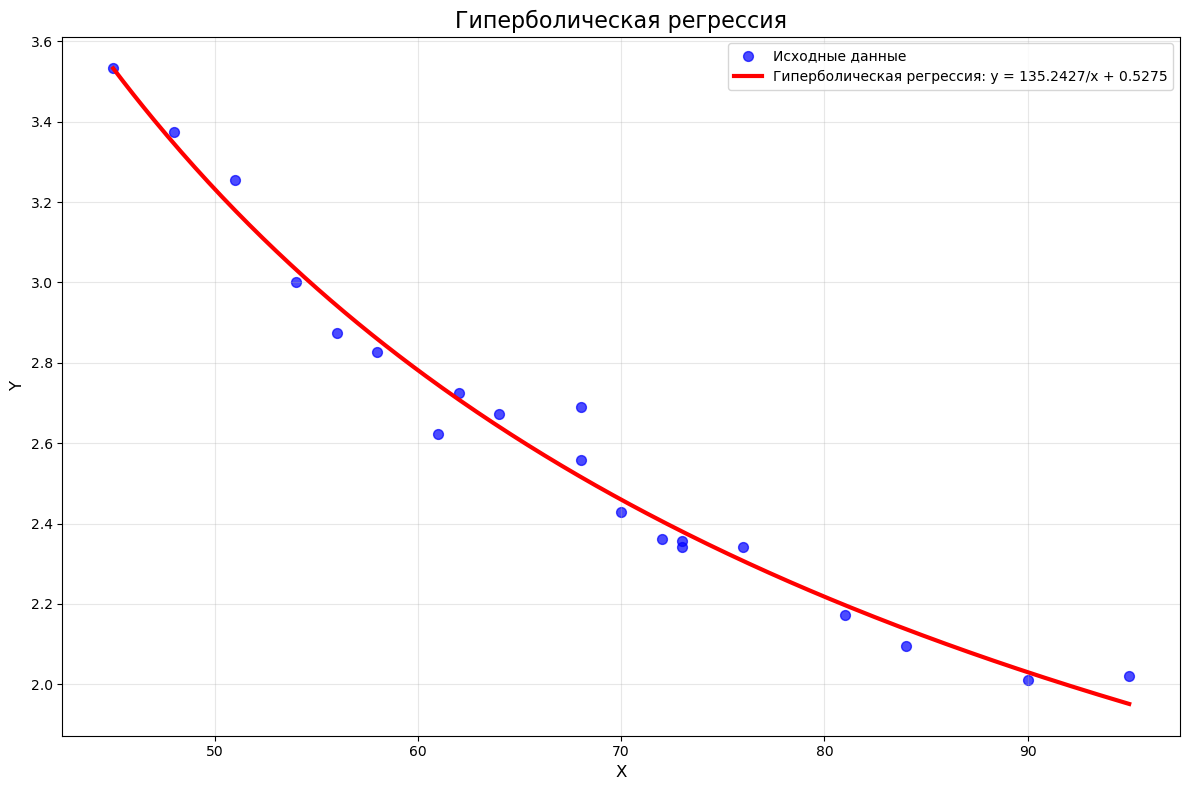

In [76]:
plot_hyperbolic_regression(x, y, coeff)

## Показательная регрессия

$y = w_1^x \cdot w_0$

In [79]:
def exponential_regression(x, y):
    y_log = np.log(y)
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y_log)
    ln_a = model.intercept_
    w0 = model.coef_[0]
    w1 = np.exp(ln_a)
    coefficients = [w1, w0]
    
    return coefficients

In [81]:
coeff = exponential_regression(x, y)
print(f'y = {coeff[0]:.4f}^x * {coeff[1]:.4f}')

y = 5.6857^x * -0.0117


In [83]:
def plot_exponential_regression(x, y, coeff, x_label="X", y_label="Y", figsize=(12, 8)):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, alpha=0.7, color='blue', s=50, label='Исходные данные')
    x_sorted = np.linspace(np.min(x), np.max(x), 300)
    a, b = coeff
    y_exp = a * np.exp(b * x_sorted)
    plt.plot(x_sorted, y_exp, 'r-', linewidth=3, label=f'Показательная регрессия: y = {coeff[0]:.4f}^x * {coeff[1]:.4f}')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title('Показательная регрессия', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

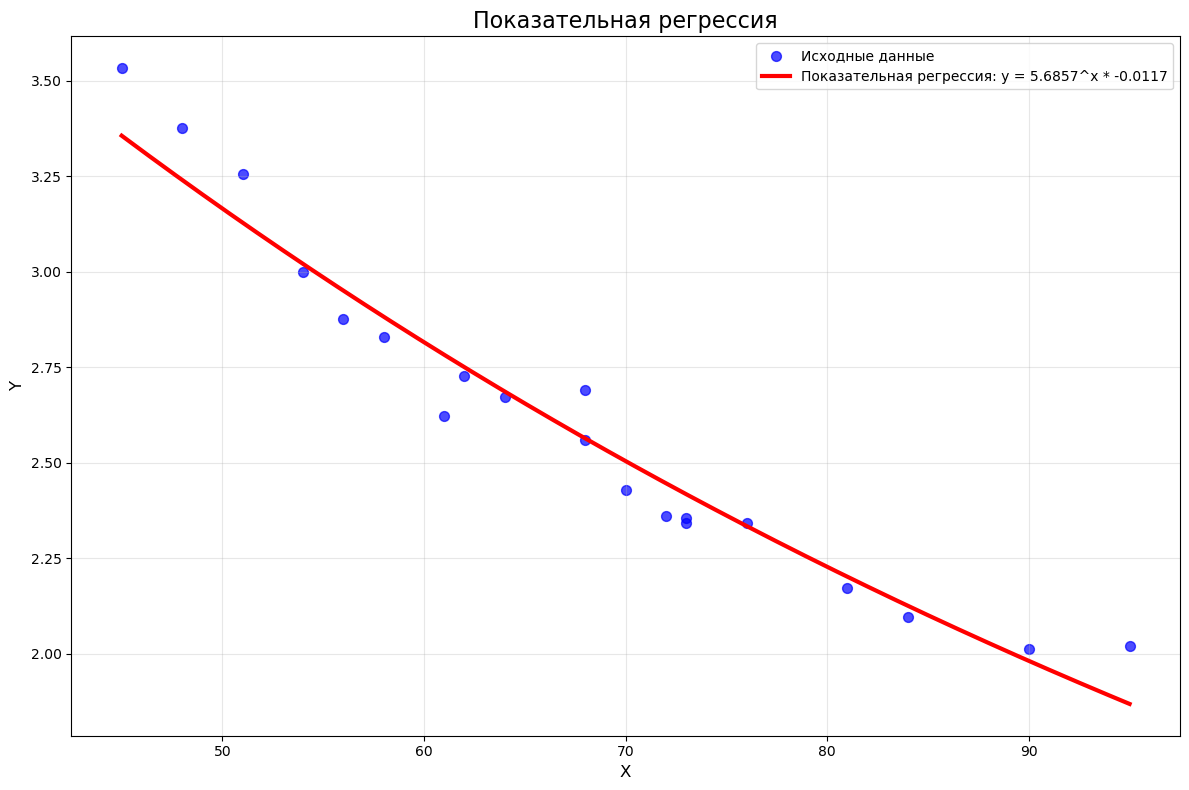

In [85]:
 plot_exponential_regression(x, y, coeff)

## Выводы

Визуальный анализ показывает, что все 4 модели достаточно точны, однако квадратичная и гиперболическая являются лучшими приближениями, когда линейная является худшей

## 4. Проверка уравнения регрессии

Для наилучшего (гиперболического) и наихудшего (линейной) уравнения регрессии проверить соотвествие модели данным с помощью критерия Фишера

$ F_{набл} = \frac{S_r / k}{S_e / (n - k - 1)} $

In [126]:
def fisher_test_regression(x, y, y_pred, k, alpha=0.05):
    y_mean = np.mean(y)
    n = len(y)
    S_t = np.sum((y - y_mean)**2)
    S_r = np.sum((y_pred - y_mean)**2)
    S_e = np.sum((y - y_pred)**2)
    F_observed = (S_r / k) / (S_e / (n - k - 1))
    F_critical = stats.f.ppf(1 - alpha, k, n - k - 1)
    is_significant = F_observed > F_critical
    print(f'F_наблюдаемая: {F_observed}')
    print(f'F_kr: {F_critical}')
    if is_significant:
        print("  F_набл > F_кр → МОДЕЛЬ ЗНАЧИМА")
        print("  Регрессионная модель адекватно описывает данные")
    else:
        print("  F_набл ≤ F_кр → МОДЕЛЬ НЕЗНАЧИМА")
        print("  Регрессионная модель неадекватно описывает данные")



Гиперболическая

In [129]:
hyper_coeffs = hyperbolic_regression(x, y)
y_pred_hyper = hyper_coeffs[0] + hyper_coeffs[1] / x

fisher_test_regression(x, y, y_pred_hyper, k = 1, alpha=0.05)

F_наблюдаемая: 844.5954708108993
F_kr: 4.413873419170566
  F_набл > F_кр → МОДЕЛЬ ЗНАЧИМА
  Регрессионная модель адекватно описывает данные


Линейная

In [119]:
w1, w0 = linear_regression(x,y)
y_pred_linear = w1*x + w0

fisher_test_regression(x, y, y_pred_linear, k = 1, alpha=0.05)

F_наблюдаемая: 17.991019841635264
F_kr: 4.413873419170566
  F_набл > F_кр → МОДЕЛЬ ЗНАЧИМА
  Регрессионная модель адекватно описывает данные


## Выводы

Таким образом критерий Фишера подтверждает гипотизы адекватности моделей